# Combined Airbnb and Evictions Analysis

### Rowana Ahmed, Sabrina Enriquez, Caroline Liongosari, Aleksandra (Teng) Ma

This notebook analyzes both the Airbnb dataset from Insider Airbnb and the Evicitions Dataset from SFData. 

In [0]:
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns

import folium
from folium.plugins import FastMarkerCluster
#import geopandas as gpd
#from branca.colormap import LinearColormap

#from pandas_profiling import ProfileReport

Loading Evictions Dataset

In [0]:
#evictions Dataset
e_df = pd.read_csv('Eviction_Notices.csv')

/Users/carolineliongosari/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
e_df.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_bh8s_q3mv,:@computed_region_9jxd_iqea,:@computed_region_6ezc_tdp2,:@computed_region_6pnf_4xz7,:@computed_region_h4ep_8xdi,Fix It Zones as of 2018-02-07
0,M200260,2800 Block Of 24th Street,San Francisco,CA,94110,02/12/2020,False,False,False,False,...,19.0,4.0,7.0,2.0,28859.0,NaN,NaN,1.0,NaN,NaN
1,M200159,400 Block Of Fillmore Street,San Francisco,CA,94117,01/28/2020,True,False,False,False,...,10.0,9.0,11.0,15.0,29492.0,NaN,NaN,1.0,NaN,NaN
2,M200271,700 Block Of Wisconsin Street,San Francisco,CA,94107,02/11/2020,False,False,False,False,...,29.0,3.0,8.0,10.0,28856.0,NaN,NaN,1.0,NaN,NaN
3,M200202,300 Block Of Serrano Drive,San Francisco,CA,94132,02/05/2020,False,True,False,False,...,14.0,8.0,4.0,1.0,64.0,NaN,NaN,2.0,NaN,NaN
4,M200169,2300 Block Of 25th Avenue,San Francisco,CA,94116,01/21/2020,False,False,False,False,...,35.0,8.0,3.0,1.0,29491.0,NaN,NaN,1.0,NaN,24.0


Data Cleaning and adding Neighborhood names by Zipcode

In [0]:
#load cleaned version of dataset
e_df = e_df.drop(columns=[':@computed_region_fyvs_ahh9', ':@computed_region_p5aj_wyqh',':@computed_region_rxqg_mtj9', ':@computed_region_yftq_j783', ':@computed_region_bh8s_q3mv', ':@computed_region_9jxd_iqea',':@computed_region_6ezc_tdp2', ':@computed_region_6pnf_4xz7', ':@computed_region_h4ep_8xdi', 'Fix It Zones as of 2018-02-07' ])

#drop columns without zipcode
e_df = e_df.dropna(axis=0, subset=['Eviction Notice Source Zipcode'])

#adding columns for Latitude and Longitude parsed from the Location column
e_df['Longitude'] = e_df.Location.str.extract(r'(?<=\()(.+?)(?=\ )', expand=True)
e_df['Latitude'] = e_df.Location.str.extract(r'(?<= (?!.* ))(.+?)(?=\))', expand=True)

e_df = e_df.dropna(axis=0, subset=['Latitude', 'City', 'State'])

e_df['Eviction Notice Source Zipcode'] = pd.to_numeric(e_df['Eviction Notice Source Zipcode'])
e_df['Eviction Notice Source Zipcode'] = e_df['Eviction Notice Source Zipcode'].astype(int)

#SF neighborhood by zipcode based on: http://www.healthysf.org/bdi/outcomes/zipmap.htm
d={94102:'Hayes Valley/Tenderloin/North of Market',
   94103:'South of Market',
   94104: 'Chinatown',
   94105:'Financial District South',
   94107:'Potrero Hill',
   94108:'Chinatown',
   94109: 'Polk/Russian Hill (Nob Hill)',
   94110: 'Inner Mission/Bernal Heights',
   94111: 'Financial District',
   94112: 'Ingelside-Excelsior/Crocker-Amazon',
   94114: 'Castro/Noe Valley',
   94115: 'Western Addition/Japantown',
   94116: 'Parkside/Forest Hill',
   94117: 'Haight-Ashbury',
   94118: 'Inner Richmond',
   94121: 'Outer Richmond',
   94122: 'Sunset',
   94123: 'Marina',
   94124: 'Bayview-Hunters Point',
   94127: 'St. Francis Wood/Miraloma/West Portal',
   94129: 'Presidio',
   94130: 'Treasure Island',
   94131: 'Twin Peaks-Glen Park',
   94132: 'Lake Merced',
   94133: 'North Beach/Chinatown',
   94134: 'Visitacion Valley/Sunnydale',
   94158: 'Mission Bay',
   94159: 'North of the Panhandle'
  }
e_df['Neighborhood by Zipcode']=e_df['Eviction Notice Source Zipcode'].map(d)

small_zip_codes = [94101, 94113, 94144, 94135, 94126]
e_df = e_df[~e_df['Eviction Notice Source Zipcode'].isin(small_zip_codes)]

In [0]:
e_df.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Supervisor District,Neighborhoods - Analysis Boundaries,Location,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Longitude,Latitude,Neighborhood by Zipcode
0,M200260,2800 Block Of 24th Street,San Francisco,CA,94110,02/12/2020,False,False,False,False,...,9.0,Mission,POINT (-122.40960340577871 37.75282207491775),53.0,3.0,2.0,20.0,-122.40960340577871,37.75282207491775,Inner Mission/Bernal Heights
1,M200159,400 Block Of Fillmore Street,San Francisco,CA,94117,01/28/2020,True,False,False,False,...,5.0,Hayes Valley,POINT (-122.43079515860666 37.77349689420376),26.0,4.0,11.0,9.0,-122.43079515860666,37.77349689420376,Haight-Ashbury
2,M200271,700 Block Of Wisconsin Street,San Francisco,CA,94107,02/11/2020,False,False,False,False,...,10.0,Potrero Hill,POINT (-122.39899123962185 37.75857987579773),54.0,2.0,9.0,26.0,-122.39899123962185,37.75857987579773,Potrero Hill
3,M200202,300 Block Of Serrano Drive,San Francisco,CA,94132,02/05/2020,False,True,False,False,...,7.0,Lakeshore,POINT (-122.48045074948287 37.71901186772143),42.0,10.0,8.0,16.0,-122.48045074948287,37.71901186772143,Lake Merced
4,M200169,2300 Block Of 25th Avenue,San Francisco,CA,94116,01/21/2020,False,False,False,False,...,4.0,Sunset/Parkside,POINT (-122.48225520781153 37.7436977235424),40.0,10.0,7.0,35.0,-122.48225520781153,37.7436977235424,Parkside/Forest Hill


Uploading Insider Airbnb Data

In [0]:
#inside airbnb data
a_df = pd.read_csv('inside_listings.csv')

/Users/carolineliongosari/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
a_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20200212052255,2020-02-12,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,...,t,f,moderate,f,f,1,1,0,0,1.81
1,5858,https://www.airbnb.com/rooms/5858,20200212052255,2020-02-12,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,none,I love how our neighborhood feels quiet but is...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.85
2,7918,https://www.airbnb.com/rooms/7918,20200212052255,2020-02-12,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,none,"Shopping old town, restaurants, McDonald, Whol...",...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.14
3,8142,https://www.airbnb.com/rooms/8142,20200212052255,2020-02-12,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.12
4,8339,https://www.airbnb.com/rooms/8339,20200212052255,2020-02-12,Historic Alamo Square Victorian,Pls email before booking. Interior featured i...,Please send us a quick message before booking ...,Pls email before booking. Interior featured i...,none,NaN,...,f,f,moderate,t,t,2,2,0,0,0.22


In [0]:
#cutting down Airbnb dataset to only the most relevant columns
a_df =  a_df[['id', 'listing_url','name','host_id', 'host_since', 'host_location','host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood','neighbourhood', 'zipcode', 'property_type', 'room_type','accommodates','bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating', 'cancellation_policy', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'latitude', 'longitude']]

In [0]:
#turn price column into floats rather than have $0.00 string format

a_df[['price']] =a_df[['price']].replace('[\$,]', '', regex=True).astype(float)

In [0]:
#a_df.info()

In [0]:
#a_df['zipcode'].value_counts()

In [0]:
#changing zipcode to strong format 

a_df['zipcode'] = a_df['zipcode'].astype('str')

In [0]:
#a_df['zipcode']

In [0]:
#a_df.info()

In [0]:
# some zipcodes had 'CA' followed by a zipcode - ex: CA 95210 
# remove CA
a_df['zipcode'] = a_df['zipcode'].map(lambda x: x.lstrip('CA '))

In [0]:
#a_df['zipcode'].value_counts()

In [0]:
#remove rows where zip code is 'nan'
a_df = a_df[~a_df['zipcode'].isin(['nan', ''])]

In [0]:
#a_df['zipcode'].value_counts()

In [0]:
# add the neighborhood names using the zipcodes

a_df['Neighborhood by Zipcode map']=a_df['zipcode'].astype(int).map(d)

In [0]:
#a_df['Neighborhood by Zipcode map'].value_counts()

In [0]:
#a_df.isnull().sum()

In [0]:
#remove rows where Neighborhood by Zipcode map is nan
a_df = a_df.dropna(axis=0, subset=['Neighborhood by Zipcode map'])

In [0]:
#get the population size for each zipcode - will be used to normalize data according to population size
pop_df = pd.read_excel('pop_size_by_zipcode.xlsx')

In [0]:
pop_df.head()

,Zipcode,Population
0,94108,9963
1,94109,37885
2,94102,21499
3,94115,20711
4,94117,19652


In [0]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
Zipcode       26 non-null int64
Population    26 non-null int64
dtypes: int64(2)
memory usage: 544.0 bytes


In [0]:
pop_df['Neighborhood by Zipcode']=pop_df['Zipcode'].astype(int).map(d)
pop_df.head() 

,Zipcode,Population,Neighborhood by Zipcode
0,94108,9963,Chinatown
1,94109,37885,Polk/Russian Hill (Nob Hill)
2,94102,21499,Hayes Valley/Tenderloin/North of Market
3,94115,20711,Western Addition/Japantown
4,94117,19652,Haight-Ashbury


In [0]:
num_airbnb_listings = a_df['Neighborhood by Zipcode map'].value_counts().rename_axis('neighborhood').reset_index(name='counts')

In [0]:
num_airbnb_listings.head()

,neighborhood,counts
0,Inner Mission/Bernal Heights,1001
1,Polk/Russian Hill (Nob Hill),723
2,Haight-Ashbury,699
3,Castro/Noe Valley,660
4,South of Market,567


In [0]:
listing_pop_merge = pd.merge(pop_df, num_airbnb_listings, left_on='Neighborhood by Zipcode',right_on='neighborhood')

In [0]:
listing_pop_merge['normalized'] = listing_pop_merge['counts']/listing_pop_merge['Population']

In [0]:
listing_pop_merge = listing_pop_merge[[ 'neighborhood', 'normalized']]

In [0]:
#listing_pop_merge is the final dataset used for analysis of the airbnb data with the neighborhood info
listing_pop_merge = listing_pop_merge.sort_values(by=['normalized'], ascending=False)

## Neighborhoods with most Airbnb listings normalized for # of properties:

1. Chinatown (by far!)
2. Castro/Noe Valley
3. Haight-Ashbury

<BarContainer object of 26 artists>

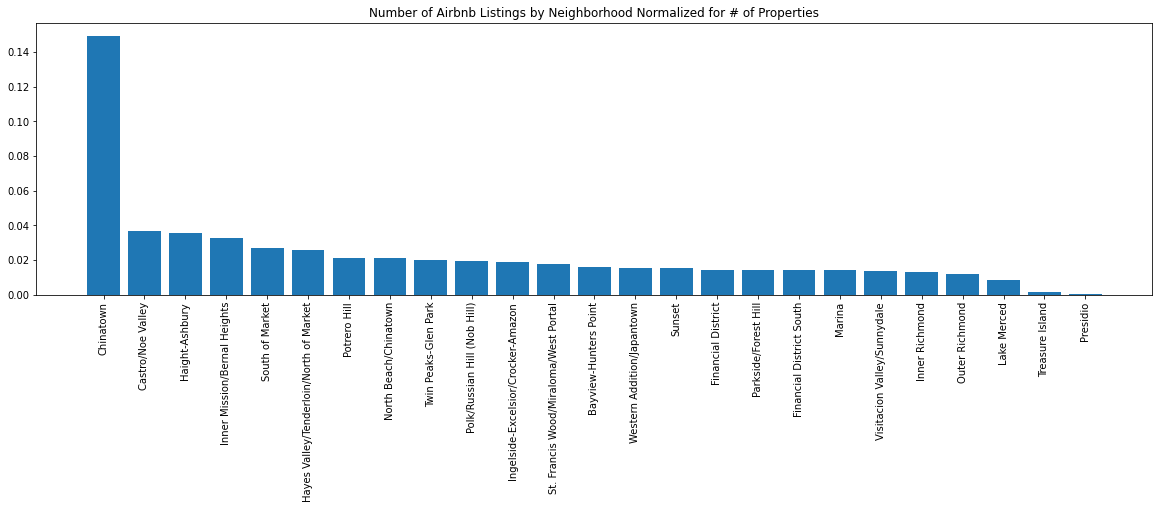

In [0]:
plt.figure(figsize=(20,5))
plt.title('Number of Airbnb Listings by Neighborhood Normalized for # of Properties')
plt.xticks(rotation=90)
plt.bar(listing_pop_merge['neighborhood'],listing_pop_merge['normalized'])


In [0]:
num_evictions = e_df['Neighborhood by Zipcode'].value_counts().rename_axis('neighborhood').reset_index(name='counts')
num_evictions.head()

,neighborhood,counts
0,Inner Mission/Bernal Heights,4913
1,Polk/Russian Hill (Nob Hill),2815
2,Haight-Ashbury,2768
3,Ingelside-Excelsior/Crocker-Amazon,2604
4,Hayes Valley/Tenderloin/North of Market,2588


In [0]:
#num evictions normalized by num_properties: https://california.hometownlocator.com/zip-codes/zipcodes,city,san%20francisco.cfm
eviction_pop_merge = pd.merge(pop_df, num_evictions, left_on='Neighborhood by Zipcode', right_on='neighborhood')
eviction_pop_merge.head()

,Zipcode,Population,Neighborhood by Zipcode,neighborhood,counts
0,94108,9963,Chinatown,Chinatown,593
1,94104,2376,Chinatown,Chinatown,593
2,94109,37885,Polk/Russian Hill (Nob Hill),Polk/Russian Hill (Nob Hill),2815
3,94102,21499,Hayes Valley/Tenderloin/North of Market,Hayes Valley/Tenderloin/North of Market,2588
4,94115,20711,Western Addition/Japantown,Western Addition/Japantown,1522


In [0]:
eviction_pop_merge['normalized'] = eviction_pop_merge['counts']/eviction_pop_merge['Population']
eviction_pop_merge = eviction_pop_merge[[ 'neighborhood', 'normalized']]
eviction_pop_merge = eviction_pop_merge.sort_values(by=['normalized'], ascending=False)

### Neighborhoods with most evictions normalized for number of properties: 
1. Inner Mission/Bernal Heights
2. Nob Hill
3. Haight-Ashbury

<BarContainer object of 26 artists>

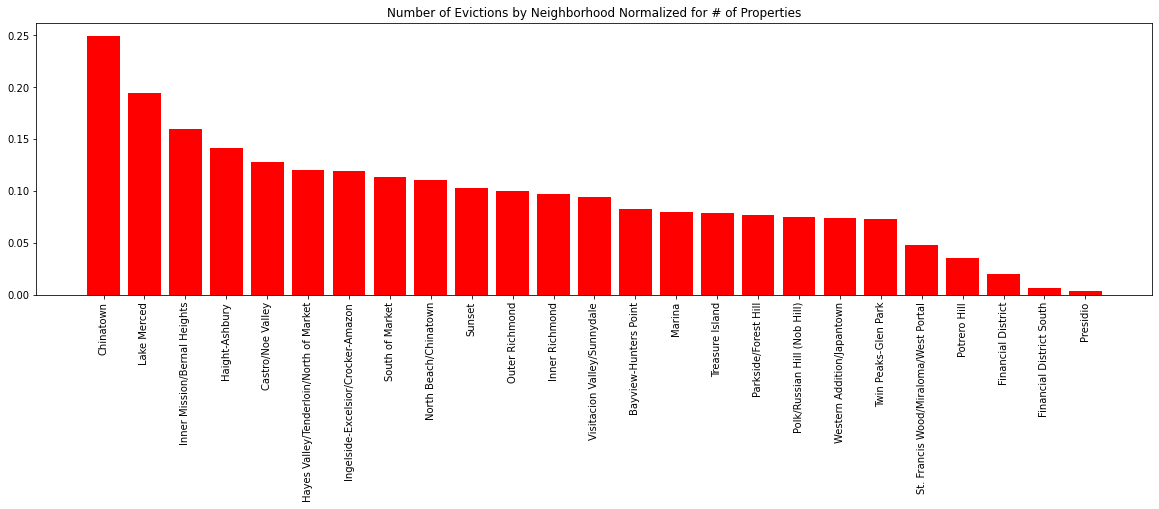

In [0]:
plt.figure(figsize=(20,5))
plt.title('Number of Evictions by Neighborhood Normalized for # of Properties')
plt.xticks(rotation=90)
plt.bar(eviction_pop_merge['neighborhood'],eviction_pop_merge['normalized'], color='Red')


## Findings

* After normalizing by number of properties, it's apparent that Chinatown has a disproportionate amount of Airbnb listings and evictions. According to https://www.sfgate.com/bayarea/article/SF-Chinatown-tenants-accuse-landlord-of-trying-to-12393516.php it seems to reflect landlords' attempts to evict low-income Chinese immigrants and replace them with more affluent tenants. The same applies for Airbnb listings: https://www.theguardian.com/us-news/2016/jul/22/airbnb-san-francisco-wanted-posters-chinatown

* Lake Merced (94132 zipcode) also has a high amount of evictions. Location of SFSU. 

* Inner Mission/Bernal Heights (94110 zipcode)

* Haight-Ashbury (94117 zipcode) is home to USF 


It seems that proximity to a university is a contributing factor to the number of evictions


# Analysis by Eviction Types

* Non Payment
* Breach
* Illegal Use
* Unapproved Subtenant
* Roommate Same Unit 

## Non Payment Evictions

<BarContainer object of 25 artists>

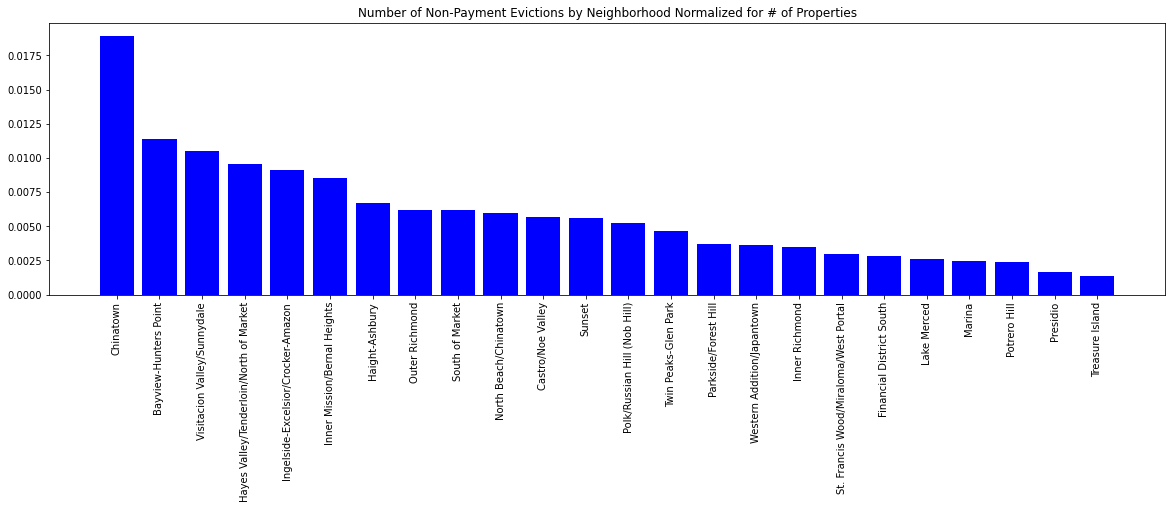

In [0]:
non_payment = e_df[e_df['Non Payment']==True].groupby('Neighborhood by Zipcode').count()['Eviction ID'].sort_values(ascending=False)
num_np = non_payment.rename_axis('neighborhood').reset_index(name='counts')
np_merge = pd.merge(pop_df, num_np, left_on='Neighborhood by Zipcode', right_on='neighborhood')

np_merge['normalized'] = np_merge['counts']/np_merge['Population']
np_merge = np_merge[[ 'neighborhood', 'normalized']]
np_merge = np_merge.sort_values(by=['normalized'], ascending=False)

plt.figure(figsize=(20,5))
plt.title('Number of Non-Payment Evictions by Neighborhood Normalized for # of Properties')
plt.xticks(rotation=90)
plt.bar(np_merge['neighborhood'],np_merge['normalized'], color='Blue')


## Breach evictions

<BarContainer object of 26 artists>

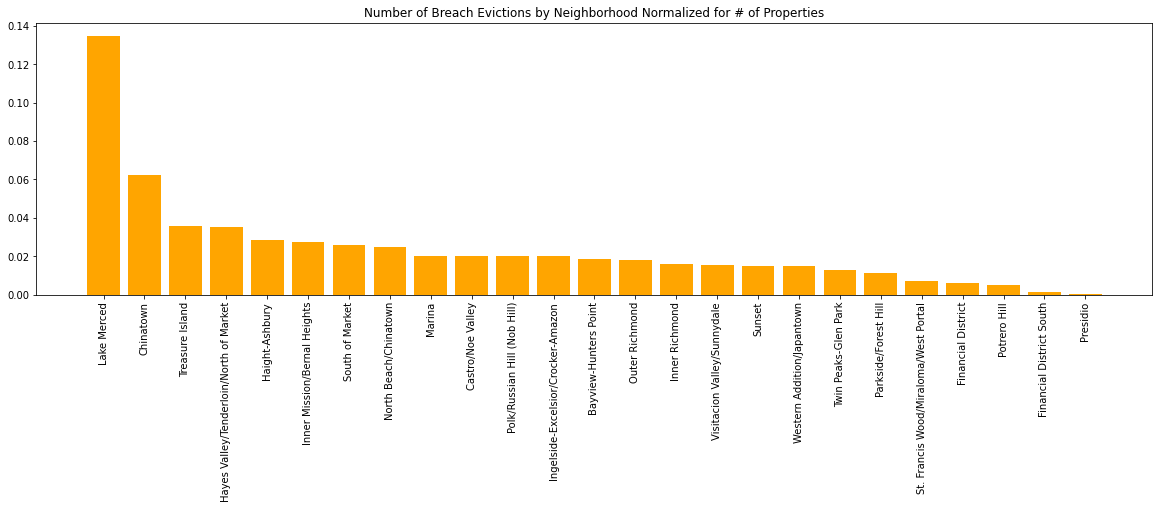

In [0]:
breach = e_df[e_df['Breach']==True].groupby('Neighborhood by Zipcode').count()['Eviction ID'].sort_values(ascending=False)
num_b = breach.rename_axis('neighborhood').reset_index(name='counts')
b_merge = pd.merge(pop_df, num_b, left_on='Neighborhood by Zipcode', right_on='neighborhood')

b_merge['normalized'] = b_merge['counts']/b_merge['Population']
b_merge = b_merge[[ 'neighborhood', 'normalized']]
b_merge = b_merge.sort_values(by=['normalized'], ascending=False)

plt.figure(figsize=(20,5))
plt.title('Number of Breach Evictions by Neighborhood Normalized for # of Properties')
plt.xticks(rotation=90)
plt.bar(b_merge['neighborhood'],b_merge['normalized'], color='Orange')

## Illegal Use Evictions

<BarContainer object of 25 artists>

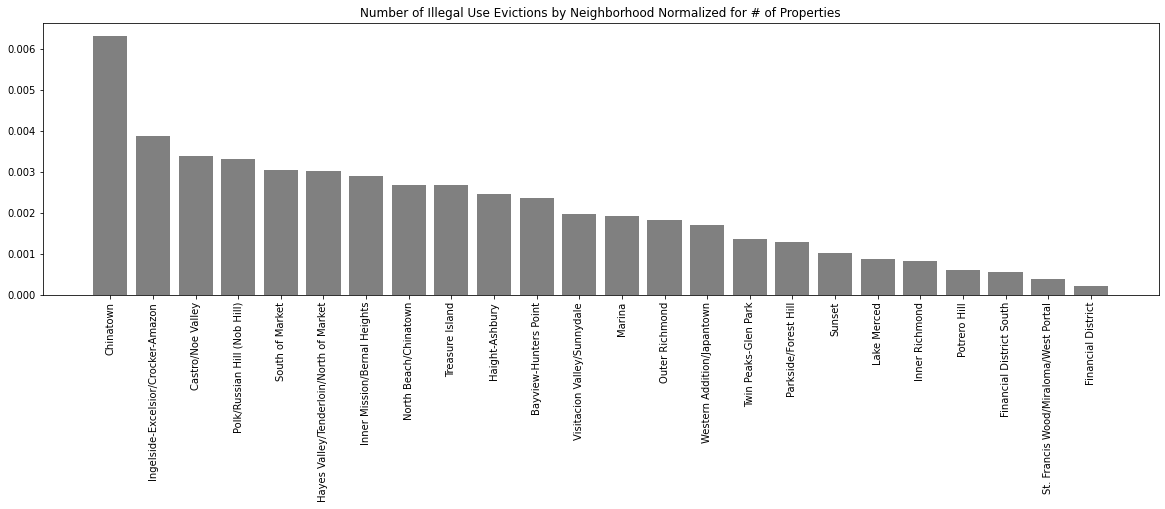

In [0]:
illegal_use = e_df[e_df['Illegal Use']==True].groupby('Neighborhood by Zipcode').count()['Eviction ID'].sort_values(ascending=False)
num_iu = illegal_use.rename_axis('neighborhood').reset_index(name='counts')
iu_merge = pd.merge(pop_df, num_iu, left_on='Neighborhood by Zipcode', right_on='neighborhood')

iu_merge['normalized'] = iu_merge['counts']/iu_merge['Population']
iu_merge = iu_merge[[ 'neighborhood', 'normalized']]
iu_merge = iu_merge.sort_values(by=['normalized'], ascending=False)

plt.figure(figsize=(20,5))
plt.title('Number of Illegal Use Evictions by Neighborhood Normalized for # of Properties')
plt.xticks(rotation=90)
plt.bar(iu_merge['neighborhood'],iu_merge['normalized'], color='Grey')



## Unapproved Subtenant Evictions


<BarContainer object of 25 artists>

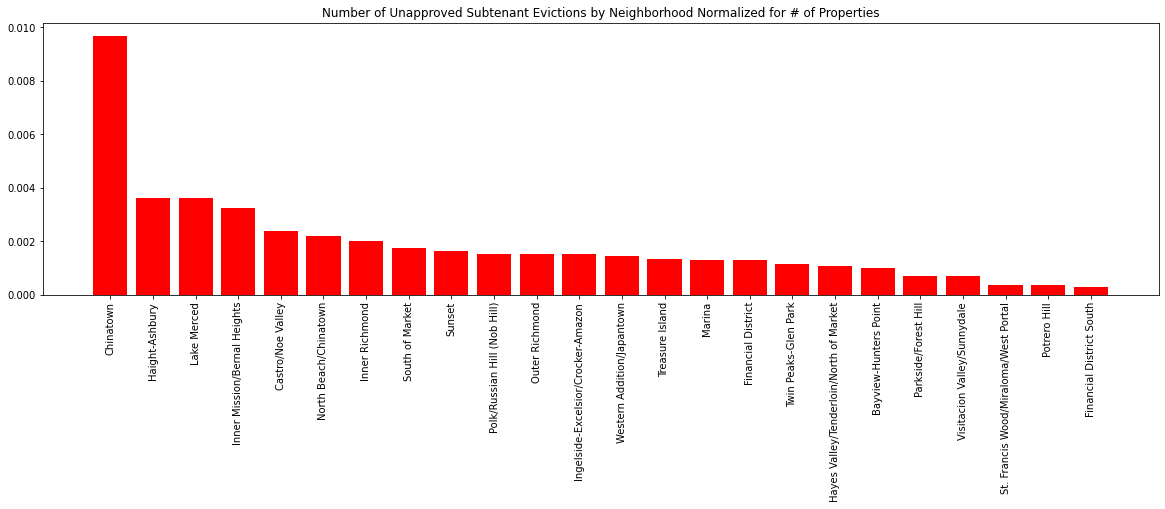

In [0]:
unapproved_subtenant = e_df[e_df['Unapproved Subtenant']==True].groupby('Neighborhood by Zipcode').count()['Eviction ID'].sort_values(ascending=False)
num_us = unapproved_subtenant.rename_axis('neighborhood').reset_index(name='counts')
us_merge = pd.merge(pop_df, num_us, left_on='Neighborhood by Zipcode', right_on='neighborhood')

us_merge['normalized'] = us_merge['counts']/us_merge['Population']
us_merge = us_merge[[ 'neighborhood', 'normalized']]
us_merge = us_merge.sort_values(by=['normalized'], ascending=False)

plt.figure(figsize=(20,5))
plt.title('Number of Unapproved Subtenant Evictions by Neighborhood Normalized for # of Properties')
plt.xticks(rotation=90)
plt.bar(us_merge['neighborhood'],us_merge['normalized'], color='Red')

## Roommate Same Unit Evictions

<BarContainer object of 25 artists>

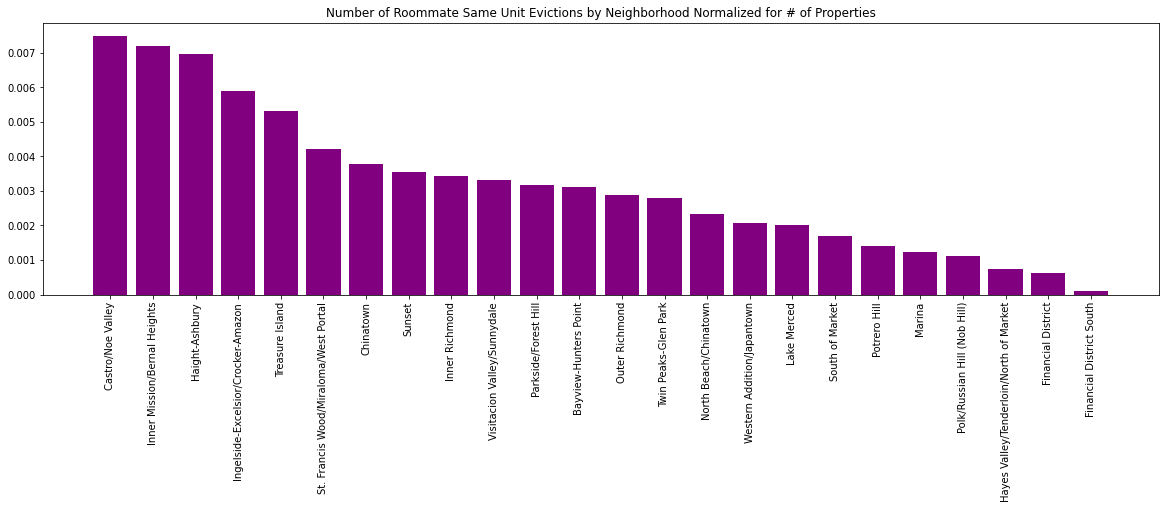

In [0]:
room_same=  e_df[e_df['Roommate Same Unit']==True].groupby('Neighborhood by Zipcode').count()['Eviction ID'].sort_values(ascending=False)
num_rs = room_same.rename_axis('neighborhood').reset_index(name='counts')
rs_merge = pd.merge(pop_df, num_rs, left_on='Neighborhood by Zipcode', right_on='neighborhood')

rs_merge['normalized'] = rs_merge['counts']/rs_merge['Population']
rs_merge = rs_merge[[ 'neighborhood', 'normalized']]
rs_merge = rs_merge.sort_values(by=['normalized'], ascending=False)

plt.figure(figsize=(20,5))
plt.title('Number of Roommate Same Unit Evictions by Neighborhood Normalized for # of Properties')
plt.xticks(rotation=90)
plt.bar(rs_merge['neighborhood'],rs_merge['normalized'], color='Purple')






## Findings

* For most eviction types (non-payment, illegal use, unapproved subtenant), Chinatown stands out to have the most evictions 

* Lake Merced has by far the most Breach Evictions

* Castro/Noe Valley has the most Roommate Same unit evictions

### Non-payment eviction: nonpayment of rent, habitual late payment or frequently bounced checks
1. Chinatown (much wider margin than rest)
2. Bayview-Hunters' Point
3. Visitacion Valley/Sunnydale

### Breach eviction: breach/violation of a term of agreement that hasn't be corrected after written notice from the landlord
1. Lake Merced (by a VERY wide margin)
2. Chinatown
3. Treasure Island

### Illegal Use evictions: illegal use of the unit
1. Chinatown
2. Ingelside-Exclesior/Crocker-Amazon
3. Castro/Noe Valley


### Unapproved Subtenant Evictions
1. Chinatown
2. Haight-Ashbury
3. Lake Merced

### Roommate Same Unit Eviction: Master tenant who lives with the subtenant evicting the subtenant
1. Castro/Noe Valley
2. Inner Mission/Bernal Heights
3. Haight-Ashbury

Seems there is definitely a relationship between number of airbnb listings and evictions




# Analysis: Taking a closer look at Chinatown's Airbnb Listings

In [0]:
chinatown_df = a_df[a_df['Neighborhood by Zipcode map']== 'Chinatown']
#chinatown_df.info()
 

In [0]:
#chinatown_df.isnull().sum()

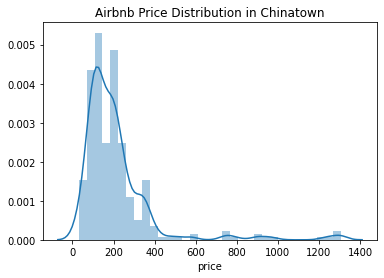

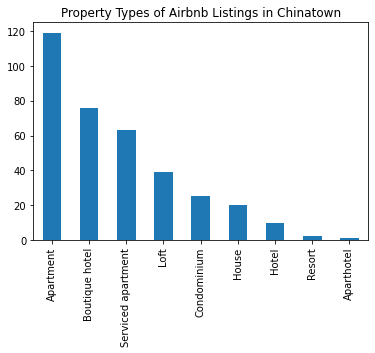

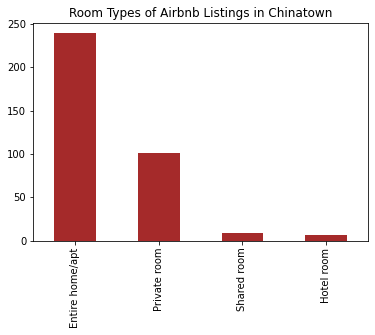

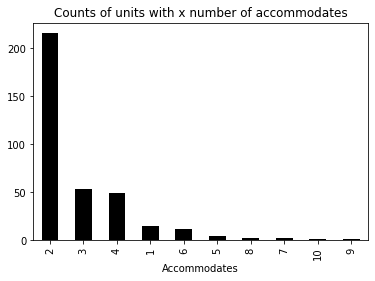

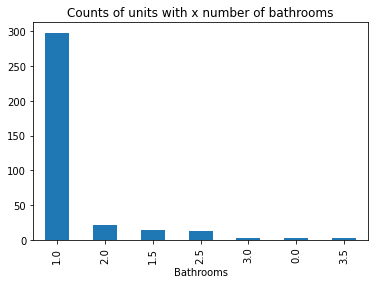

In [0]:
#airbnb prices distribution in Chinatown
plt.title('Airbnb Price Distribution in Chinatown')
dist = chinatown_df["price"]
sns.distplot(dist)
plt.show()

plt.title('Property Types of Airbnb Listings in Chinatown')
chinatown_df['property_type'].value_counts().plot(kind='bar')
plt.show()

plt.title('Room Types of Airbnb Listings in Chinatown')
chinatown_df['room_type'].value_counts().plot(kind='bar', color='Brown')
plt.show()

dist = chinatown_df["accommodates"].value_counts()
dist.plot(kind='bar', color='black')
plt.title('Counts of units with x number of accommodates')
plt.xlabel('Accommodates')
plt.show()

dist2 = chinatown_df["bathrooms"].value_counts()
dist2.plot(kind='bar')
plt.title('Counts of units with x number of bathrooms')
plt.xlabel('Bathrooms')
plt.show()



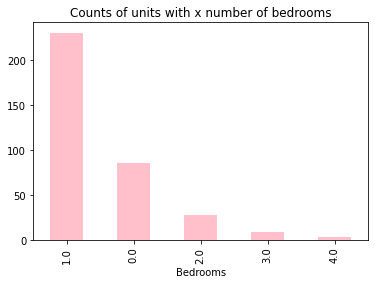

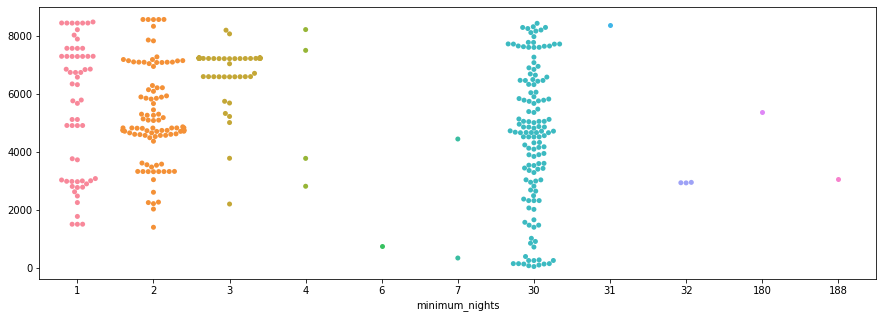

In [0]:
dist3 = chinatown_df["bedrooms"].value_counts()
dist3.plot(kind='bar', color='pink')
plt.title('Counts of units with x number of bedrooms')
plt.xlabel('Bedrooms')
plt.show()

df2 = chinatown_df['minimum_nights']
f,ax = plt.subplots(figsize=(15,5))
ax = sns.swarmplot(y= df2.index,x= df2.values)
plt.xlabel("minimum_nights")
plt.show()

## Findings

Chinatown's Airbnb listings are mostly composed of Entire apartments/homes, botique hotels,  or serviced apartments accommodating 2 people (2 beds, 2 baths and majority require 30 days minimum nights

So there's mostly long term stays

# Analysis: Lake Merced's Airbnb Listings
Lake Merced has a disportionate amount of breach evictions, 3rd for unapproved subtenant evictions

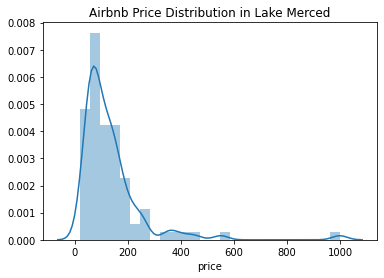

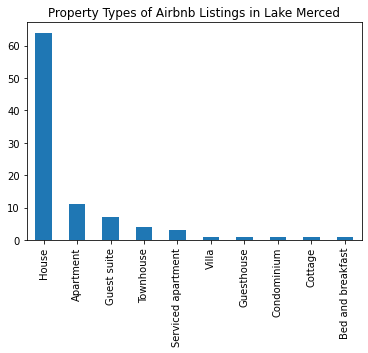

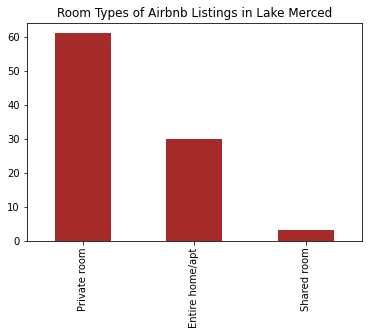

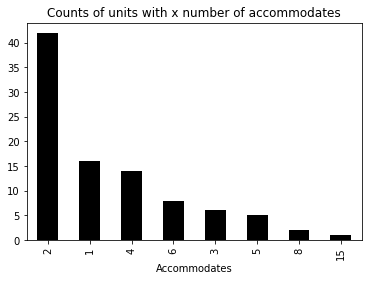

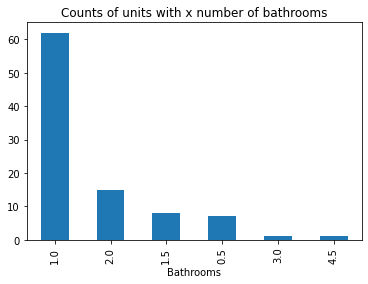

In [0]:
lm_df = a_df[a_df['Neighborhood by Zipcode map']== 'Lake Merced']
#airbnb prices distribution in Chinatown
plt.title('Airbnb Price Distribution in Lake Merced')
dist = lm_df["price"]
sns.distplot(dist)
plt.show()

plt.title('Property Types of Airbnb Listings in Lake Merced')
lm_df['property_type'].value_counts().plot(kind='bar')
plt.show()

plt.title('Room Types of Airbnb Listings in Lake Merced')
lm_df['room_type'].value_counts().plot(kind='bar', color='Brown')
plt.show()

dist = lm_df["accommodates"].value_counts()
dist.plot(kind='bar', color='black')
plt.title('Counts of units with x number of accommodates')
plt.xlabel('Accommodates')
plt.show()

dist2 = lm_df["bathrooms"].value_counts()
dist2.plot(kind='bar')
plt.title('Counts of units with x number of bathrooms')
plt.xlabel('Bathrooms')
plt.show()


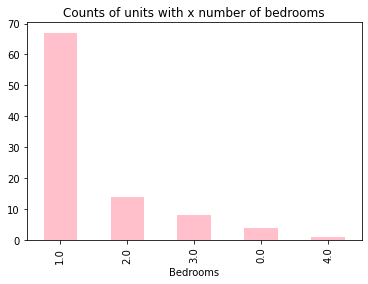

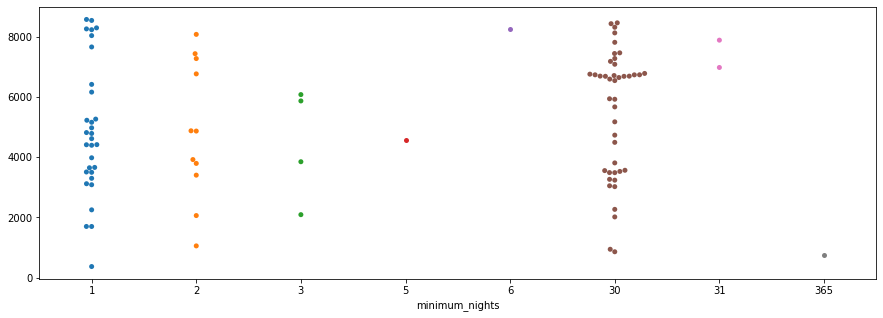

In [0]:
dist3 = lm_df["bedrooms"].value_counts()
dist3.plot(kind='bar', color='pink')
plt.title('Counts of units with x number of bedrooms')
plt.xlabel('Bedrooms')
plt.show()

df2 = lm_df['minimum_nights']
f,ax = plt.subplots(figsize=(15,5))
ax = sns.swarmplot(y= df2.index,x= df2.values)
plt.xlabel("minimum_nights")
plt.show()

## Findings: 
* Unlike Chinatown where most Aribnb listings are for entire buildings, Lake Merced's mostly has listings of a private room in a house.
* Most listings only consist of a bedroom and a bathroom
* Prices are also a bit cheaper than Chinatown, mostly below $100
* While it looks like Lake Merced mostly has 30-days minimum listings, there's more 1-day minimums than Chinatown




# Analysis: Castro/Noe Valley's Airbnb Listings
Castro/Noe Valley has the most rommate same unit evictions

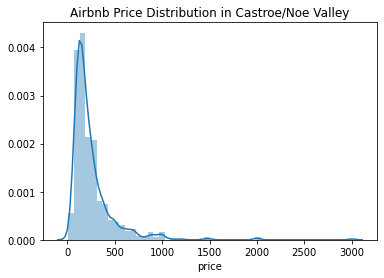

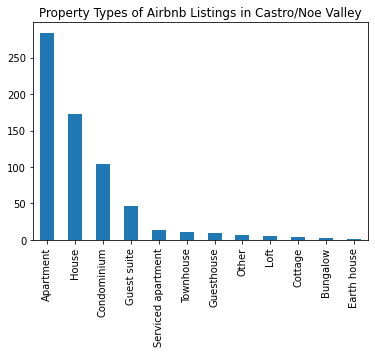

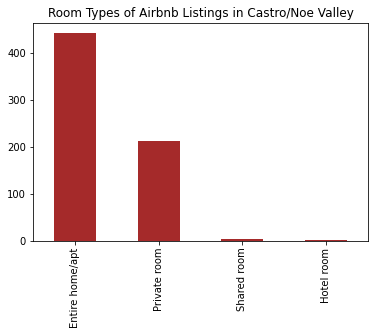

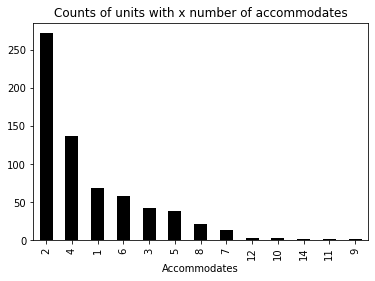

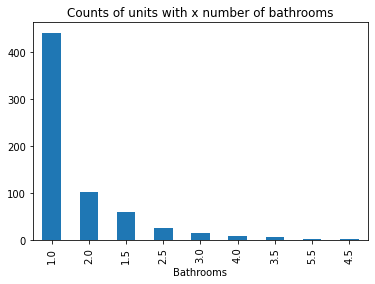

In [0]:
cv_df = a_df[a_df['Neighborhood by Zipcode map']== 'Castro/Noe Valley']
#airbnb prices distribution in Chinatown
plt.title('Airbnb Price Distribution in Castroe/Noe Valley')
dist = cv_df["price"]
sns.distplot(dist)
plt.show()

plt.title('Property Types of Airbnb Listings in Castro/Noe Valley')
cv_df['property_type'].value_counts().plot(kind='bar')
plt.show()

plt.title('Room Types of Airbnb Listings in Castro/Noe Valley')
cv_df['room_type'].value_counts().plot(kind='bar', color='Brown')
plt.show()

dist = cv_df["accommodates"].value_counts()
dist.plot(kind='bar', color='black')
plt.title('Counts of units with x number of accommodates')
plt.xlabel('Accommodates')
plt.show()

dist2 =cv_df["bathrooms"].value_counts()
dist2.plot(kind='bar')
plt.title('Counts of units with x number of bathrooms')
plt.xlabel('Bathrooms')
plt.show()


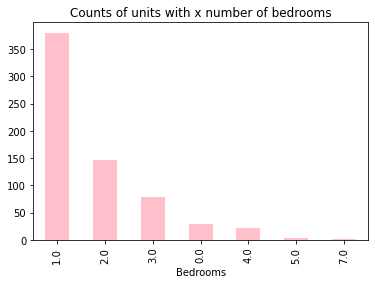

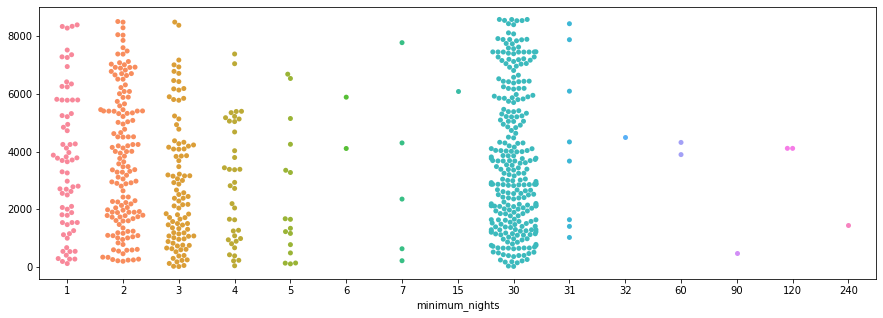

In [0]:
dist3 = cv_df["bedrooms"].value_counts()
dist3.plot(kind='bar', color='pink')
plt.title('Counts of units with x number of bedrooms')
plt.xlabel('Bedrooms')
plt.show()

df2 = cv_df['minimum_nights']
f,ax = plt.subplots(figsize=(15,5))
ax = sns.swarmplot(y= df2.index,x= df2.values)
plt.xlabel("minimum_nights")
plt.show()

## Findings: 
* Castro/Noe Valley has similar listings as Chinatown (entire apartments) 
* But, most listings only have 1 bed and 1 bath even though most of the listings have 2 accommodates
* There's more listings than Chinatown and Lake Merced that have 4 accommodates
* While it looks like there's more 30-days minimum listings, there's variation in number of minimum days (1-4)
* Smaller apartments, more roommates, more short term stay listings

# Inner Mission/Bernal Heights
3rd highest amount of evictions, 4th high amount of listings 
2nd highest amount of roommate same unit evictions, 4th in unapproved subtenant evictions

In [0]:
im_df["price"].max()

NameError: name 'im_df' is not defined

In [0]:
 im_df["price"].median()

In [0]:
im_df = a_df[a_df['Neighborhood by Zipcode map']== 'Inner Mission/Bernal Heights']
#airbnb prices distribution in Chinatown
plt.title('Airbnb Price Distribution in  Inner Mission/Bemal Heights')
dist = im_df["price"]
sns.distplot(dist)
plt.show()

plt.title('Property Types of Airbnb Listings in Inner Mission/Bernal Heights')
im_df['property_type'].value_counts().plot(kind='bar')
plt.show()

plt.title('Room Types of Airbnb Listings in Inner Mission/Bernal Heights')
im_df['room_type'].value_counts().plot(kind='bar', color='Brown')
plt.show()

dist = im_df["accommodates"].value_counts()
dist.plot(kind='bar', color='black')
plt.title('Counts of units with x number of accommodates')
plt.xlabel('Accommodates')
plt.show()

dist2 =im_df["bathrooms"].value_counts()
dist2.plot(kind='bar')
plt.title('Counts of units with x number of bathrooms')
plt.xlabel('Bathrooms')
plt.show()

In [0]:
dist3 = im_df["bedrooms"].value_counts()
dist3.plot(kind='bar', color='pink')
plt.title('Counts of units with x number of bedrooms')
plt.xlabel('Bedrooms')
plt.show()

df2 = im_df['minimum_nights']
f,ax = plt.subplots(figsize=(15,5))
ax = sns.swarmplot(y= df2.index,x= df2.values)
plt.xlabel("minimum_nights")
plt.show()

## Findings: 
* Wide variation in number of minimum days, but most common is still 30 days
* Even though the vast majorty of listings are entire apartments/homes with 1 bed, 1 bath, it's expected to have 2-4 accommodates, showing that many people try to squeeze in a single listing
* Median listing price is about $200

## Financial District's Airbnb Listings
* Relatively more listings, very low number of evictions

In [0]:
fd_df = a_df[a_df['Neighborhood by Zipcode map']== 'Financial District']
#airbnb prices distribution in Chinatown
plt.title('Airbnb Price Distribution in Financial District')
dist = fd_df["price"]
sns.distplot(dist)
plt.show()

plt.title('Property Types of Airbnb Listings in Financial District')
fd_df['property_type'].value_counts().plot(kind='bar')
plt.show()

plt.title('Room Types of Airbnb Listings in Financial District')
fd_df['room_type'].value_counts().plot(kind='bar', color='Brown')
plt.show()

dist = fd_df["accommodates"].value_counts()
dist.plot(kind='bar', color='black')
plt.title('Counts of units with x number of accommodates')
plt.xlabel('Accommodates')
plt.show()

dist2 =fd_df["bathrooms"].value_counts()
dist2.plot(kind='bar')
plt.title('Counts of units with x number of bathrooms')
plt.xlabel('Bathrooms')
plt.show()


In [0]:
dist3 = fd_df["bedrooms"].value_counts()
dist3.plot(kind='bar', color='pink')
plt.title('Counts of units with x number of bedrooms')
plt.xlabel('Bedrooms')
plt.show()

df2 = fd_df['minimum_nights']
f,ax = plt.subplots(figsize=(15,5))
ax = sns.swarmplot(y= df2.index,x= df2.values)
plt.xlabel("minimum_nights")
plt.show()

## Findings: 
* Most listings in the Financial District are on the expensive side ($200+)
* Most are also requiring long term stays (30+ days)
* Most common kind of listings are full apartments/home (1 bedroom (or not - like a studio) and 1 bathroom, but there's also significant number of serviced apartment, hostel, and condo listings




## Potrero Hill's Airbnb Listings
* Relatively more listings than Financial District, very low number of evictions (1 above Financial district)

In [0]:
ph_df = a_df[a_df['Neighborhood by Zipcode map']== 'Potrero Hill']
#airbnb prices distribution in Chinatown
plt.title('Airbnb Price Distribution in Potrero Hill')
dist = ph_df["price"]
sns.distplot(dist)
plt.show()

plt.title('Property Types of Airbnb Listings in Potrero Hill')
ph_df['property_type'].value_counts().plot(kind='bar')
plt.show()

plt.title('Room Types of Airbnb Listings in Potrero Hill')
ph_df['room_type'].value_counts().plot(kind='bar', color='Brown')
plt.show()

dist = ph_df["accommodates"].value_counts()
dist.plot(kind='bar', color='black')
plt.title('Counts of units with x number of accommodates')
plt.xlabel('Accommodates')
plt.show()

dist2 = ph_df["bathrooms"].value_counts()
dist2.plot(kind='bar')
plt.title('Counts of units with x number of bathrooms')
plt.xlabel('Bathrooms')
plt.show()

In [0]:
dist3 = ph_df["bedrooms"].value_counts()
dist3.plot(kind='bar', color='pink')
plt.title('Counts of units with x number of bedrooms')
plt.xlabel('Bedrooms')
plt.show()

df2 = ph_df['minimum_nights']
f,ax = plt.subplots(figsize=(15,5))
ax = sns.swarmplot(y= df2.index,x= df2.values)
plt.xlabel("minimum_nights")
plt.show()

## Findings: 
*  Prices are cheaper than Financial District ($100+)
*  Most common listings include entire homes/apartments (1 bed, 1 bath), 2 accommodates
*  Greater variation in minimum nights to stay (1-5 nights) with most still being 30 days
* Like the financial distrct, also has more serviced apartments 

# Overall Findings

* There's definitely a correlation between the number of Airbnb listings available and the number of evictions 
* Chinatown stands out by having proportionately more Airbnb Listings and evictions than any other SF neighborhood. It's characterized for mainly having listings that are long term stays (30+ nights).
* Lake Merced, having the most breach evictions and a high number of unapproved subtenant evictions, actually has relatively few Airbnb listings (3rd to last), showing that high eviction rates cannot be only caused by Airbnb

